In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table

plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import glob
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet


# from utils import *

07_10_25


In [2]:
files_113 = glob.glob('../data/p113_data/*.fits')
files_112 = glob.glob('../data/p112_data/*.fits')
li_line = 6707.926


In [103]:
def get_files(files):
    obj_dir = {}
    c=3e5 #km/s

    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            grade   = header['OB_GRADE'].replace(" ", "")
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err
            if name=='UCAC4 308-077592':
                if obj in obj_dir.keys():
                    obj_dir[obj]['file'].append(file)
                    obj_dir[obj]['rv'].append(rv_corr)
                    obj_dir[obj]['time'].append(time)
                    obj_dir[obj]['err'].append(err_corr)
                    obj_dir[obj]['name'].append(name)
                    obj_dir[obj]['grade'].append(grade)
                else:
                    obj_dir[obj] = {'file': [file], 'rv': [rv_corr], 
                                    'time': [time], 'err': [err_corr], 
                                    'name': [name], 'grade': [grade]}
            else:
                if rv_corr >= -100:
                    if obj in obj_dir.keys():
                        obj_dir[obj]['file'].append(file)
                        obj_dir[obj]['rv'].append(rv_corr)
                        obj_dir[obj]['time'].append(time)
                        obj_dir[obj]['err'].append(err_corr)
                        obj_dir[obj]['name'].append(name)
                        obj_dir[obj]['grade'].append(grade)
                    else:
                        obj_dir[obj] = {'file': [file], 'rv': [rv_corr], 
                                        'time': [time], 'err': [err_corr], 
                                        'name': [name], 'grade': [grade]}
    print(len(obj_dir.keys()))   
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}
    return obj_dir
obj_dir_112 = get_files(files_112)
obj_dir_113 = get_files(files_113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
19
10
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25
25


In [104]:
def rv_correct(rg, obj_dir,plot=False):
    c = 3e5 #km/s
    files = obj_dir[rg]['file']
    rvs    = obj_dir[rg]['rv']
    plt.figure(figsize=(15,10))

    all_flux = []
    all_wave = []
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header = hdul[0].header
            data  = hdul[1].data
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
            mask       = (wave > 3800)
            wave, flux = wave[mask], flux[mask]
            plt.subplot(len(files),1,i+1)
            plt.plot(wave, flux, lw=0.5)
            plt.axvline(li_line,c='C1')
            plt.xlim(6700, 6717)
            mask = (wave >= 6708) & (wave <= 6710)
            new_wave = wave[mask]
            new_flux = flux[mask]
            w0 = li_line*1
            w1 = new_wave[np.argmin(new_flux)]
            shift = (rv_val/c)*(w0)
            #print((w1 - w0)*c/w0, rv_val, shift)
            plt.plot(wave-shift, flux)
            
            corrected_wave = wave-shift
            all_wave.append(corrected_wave)
            all_flux.append(flux)            
    plt.tight_layout()
    if not plot: plt.close()
    return all_wave, all_flux
    
rv_correct(1, obj_dir_112)


([array([3798.80378991, 3798.81012757, 3798.81646524, ..., 7896.57937194,
         7896.59254364, 7896.60571536]),
  array([3798.80161183, 3798.80794949, 3798.81428716, ..., 7896.57719386,
         7896.59036556, 7896.60353728]),
  array([3798.80346167, 3798.80979933, 3798.81613701, ..., 7896.57904371,
         7896.59221541, 7896.60538713]),
  array([3798.80920814, 3798.8155458 , 3798.82188348, ..., 7896.58479018,
         7896.59796188, 7896.6111336 ])],
 [array([8.08440187e-14, 3.11351532e-14, 6.81372403e-14, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00], dtype='>f8'),
  array([-5.26818120e-14, -1.47251443e-14, -1.60365062e-14, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00], dtype='>f8'),
  array([ 1.38933322e-14, -1.86903781e-15,  1.50918206e-14, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00], dtype='>f8'),
  array([ 4.69601195e-15, -3.96195973e-14,  3.61402349e-15, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],

In [55]:
def interp_wave(w, f):
    '''
    interpolate all the wavelength to same grid for target spectrum
    @input:
        w : original wavelength grid of each observation after RV correction
        f : flux values of each observation
    '''
    
    wave_grid = w[0]

    all_flux = []
    all_flux.append(f[0])
    
    for i in range(1,len(w)):
        target_wave, target_flux = w[i],f[i]
        target_flux_interp = np.interp(wave_grid, target_wave, target_flux)
        all_flux.append(target_flux_interp)
       
    return wave_grid, all_flux

    

In [6]:
def stack(all_flux,plot=False):
    stacked = np.sum(np.array(all_flux), axis=0)
    if plot:# plot stacked spectra
        plt.figure(figsize=(10,4))

        for spectrum in all_flux:
            plt.plot(w,spectrum)

        plt.plot(w,stacked,label='stacked')
        plt.legend()
        plt.xlim(6550,6570)
        plt.ylim(0,0.4e-12)

        plt.tight_layout()
    return stacked


In [54]:
def load_template(RG, program):
    
    table4 = pd.read_csv('table4.csv')
    rv_df = pd.read_csv('comb_rvs.csv')
    vbroad = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)].vbroad.values[0]

    templates = glob.glob('../files/Arcturus_templates/arcturus_*.txt')
    fname = '../files/Arcturus_templates/arcturus_vsini_%s.txt'%vbroad
    
    print(vbroad, fname)    
    
    template_og = pd.read_csv(fname,delimiter=' ')
    return template_og


In [52]:
def interp_template(wave_grid, template,plot=False):
    
    min_wave_esp, max_wave_esp = min(wave_grid), max(wave_grid)
    
    template = template[(template.waveobs <= max_wave_esp) & (template.waveobs >= min_wave_esp)]
    temp_wave = np.array(template.waveobs)
    temp_flux = np.array(template.flux)
    temp_flux_interp = np.interp(wave_grid, temp_wave, temp_flux)

    print('N points in target spectrum:',len(wave_grid))
    print('N points in template spectrum:',len(temp_wave))
    if plot:
        plt.figure(figsize=(10,4),dpi=200)

        plt.plot(temp_wave, temp_flux, label='OG template')
        plt.plot(wave_grid, temp_flux_interp, label='interpolate template')
        plt.xlim(6550,6570)
        plt.ylim(0.5,1.1)
    return temp_flux_interp


In [62]:
percentage=20
percentage /= 100
lower, upper = 1+percentage,1-percentage,
lower,upper    

(1.2, 0.8)

In [67]:
def id_cont(wave, flux, percentage=5):
    '''
    identify continuum
    percentage of spectra to mask out; default is 5%
    '''
    percentage /= 100
    lower, upper = 1-percentage,1+percentage,
    mask = (flux<=upper) & (flux>=lower)
    return mask
    
def fit_cont(wave, flux, order=3):
    '''
    fit the continuum with polynomial
    '''
    coefficients  = np.polyfit(wave, flux, order) # Fit a n-order polynomial
    poly_function = np.poly1d(coefficients)
    fitted_flux   = poly_function(wave)
    return poly_function
    

In [125]:
def pipeline(RG, obj_dir, program, percentage=5, close=False, savefig=False, savetxt=False):
    
    # load RV corrected spectra
    wave, flux      = rv_correct(RG, obj_dir)
    
    # interpolate RV corrected spectra onto one grid
    wave_grid, flux = interp_wave(wave, flux)
    
    # stack all target spectrum
    stacked_flux    = stack(flux,plot=False)
    target_flux     = stacked_flux*1

    # load template based on each target's vbroad
    template        = load_template(RG, program)
    
    # interpolate the template onto target spectrum grid
    temp_flux_interp = interp_template(wave_grid, template)           
    
    # identify the continuum in the template
    cont_mask        = id_cont(wave_grid, temp_flux_interp, percentage) 
    
    plt.figure(figsize=(10,4),dpi=200)
    plt.plot(wave_grid, temp_flux_interp)
    plt.plot(wave_grid[cont_mask], temp_flux_interp[cont_mask])
    plt.xlim(6550,6570)
    if close: plt.close()

    # mask out the continuum indices in the target spectrum
    cont_wave, cont_flux = wave_grid[cont_mask], target_flux[cont_mask]
    
    fig = plt.figure(figsize=(10,10),dpi=200)
    ax1 = plt.subplot(311)
    plt.plot(wave_grid, target_flux, label='target flux (unnormalized)')
    plt.plot(cont_wave, cont_flux, label='continuum identified (unnormalized)')
    plt.legend()
    plt.xlim(6550,6570)
    #if close: plt.close()
    
    # fit a polynomial to the continuum in the target spectrum
    poly_func = fit_cont(cont_wave, cont_flux)
    
    # divide the original target flux values by the function
    target_flux_norm = stacked_flux/poly_func(wave_grid) 
    
    plt.subplot(312)
    plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
    plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
    plt.legend()
    plt.title('H-alpha line')
    plt.xlim(6550,6570)
    plt.ylim(0.,1.2)
    
    plt.subplot(313)
    plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
    plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
    plt.legend()
    plt.title('Li line')
    plt.xlim(6700, 6710)
    plt.ylim(0.,1.2)

    rv_df = pd.read_csv('comb_rvs.csv')
    rv_df = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)]
    Li_val = rv_df.Li_val.values[0]
    vbroad = rv_df.vbroad.values[0]
    
    title = 'P%s RG%s:    Li = %.1f    vbroad = %.1f' % (program, RG, Li_val, vbroad)
    ax1.set_title(title)

    plt.tight_layout()
    if savefig: plt.savefig('../files/normalized_spectra_png/%s_%s.png'%(program, RG))
    if close: plt.close()
    
    spectrum = np.array([wave_grid, target_flux_norm]).T
    savedir  = '../files/normalized_spectra/'
    fname    = savedir+'%s_%s.txt'%(program, RG)
    print(fname)
    if savetxt: np.savetxt(fname,spectrum)
    


In [123]:
plt.rcParams['figure.facecolor'] = 'white'


In [126]:
for RG in obj_dir_113.keys():
    pipeline(RG,obj_dir_113,113,close=True,savefig=True,savetxt=False)

18.76 ../files/Arcturus_templates/arcturus_vsini_18.76.txt
N points in target spectrum: 438657
N points in template spectrum: 594638
../files/normalized_spectra/113_1.txt
7.02 ../files/Arcturus_templates/arcturus_vsini_7.02.txt
N points in target spectrum: 438657
N points in template spectrum: 594436
../files/normalized_spectra/113_2.txt
15.34 ../files/Arcturus_templates/arcturus_vsini_15.34.txt
N points in target spectrum: 438657
N points in template spectrum: 594695
../files/normalized_spectra/113_3.txt
10.95 ../files/Arcturus_templates/arcturus_vsini_10.95.txt
N points in target spectrum: 438657
N points in template spectrum: 594663
../files/normalized_spectra/113_4.txt
6.92 ../files/Arcturus_templates/arcturus_vsini_6.92.txt
N points in target spectrum: 438657
N points in template spectrum: 594274
../files/normalized_spectra/113_5.txt
27.1 ../files/Arcturus_templates/arcturus_vsini_27.1.txt
N points in target spectrum: 438657
N points in template spectrum: 594651
../files/normalize

In [130]:
obj_dir_112.keys()

dict_keys([1, 2, 4, 5, 6, 7, 13, 14, 23, 24])

In [131]:
for RG in obj_dir_112.keys():
    if RG != 24: continue
    pipeline(RG,obj_dir_112,112,close=True,savefig=True,savetxt=False)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [108]:
for RG in obj_dir_112.keys():
    pipeline(RG,obj_dir_112,112,close=True)

11.29 ../files/Arcturus_templates/arcturus_vsini_11.29.txt
N points in target spectrum: 438657
N points in template spectrum: 594711
../files/normalized_spectra/112_1.txt
11.37 ../files/Arcturus_templates/arcturus_vsini_11.37.txt
N points in target spectrum: 438657
N points in template spectrum: 594657
../files/normalized_spectra/112_2.txt
8.79 ../files/Arcturus_templates/arcturus_vsini_8.79.txt
N points in target spectrum: 438657
N points in template spectrum: 594702
../files/normalized_spectra/112_4.txt
7.49 ../files/Arcturus_templates/arcturus_vsini_7.49.txt
N points in target spectrum: 438657
N points in template spectrum: 594845
../files/normalized_spectra/112_5.txt
7.95 ../files/Arcturus_templates/arcturus_vsini_7.95.txt
N points in target spectrum: 438657
N points in template spectrum: 594566
../files/normalized_spectra/112_6.txt
10.03 ../files/Arcturus_templates/arcturus_vsini_10.03.txt
N points in target spectrum: 438657
N points in template spectrum: 594582
../files/normalize

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
ss

25.94 ../files/Arcturus_templates/arcturus_vsini_25.94.txt
N points in target spectrum: 438657
N points in template spectrum: 594586


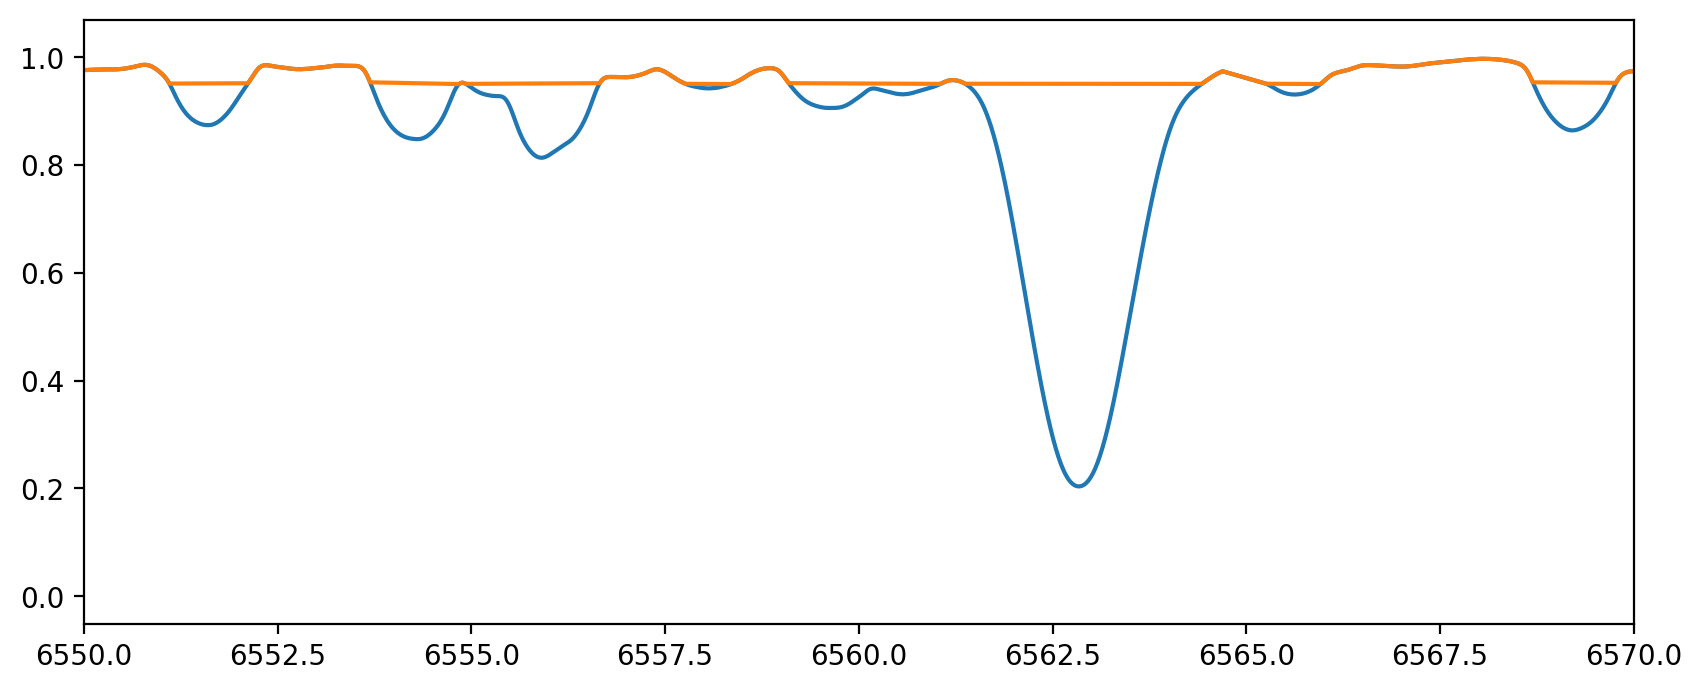

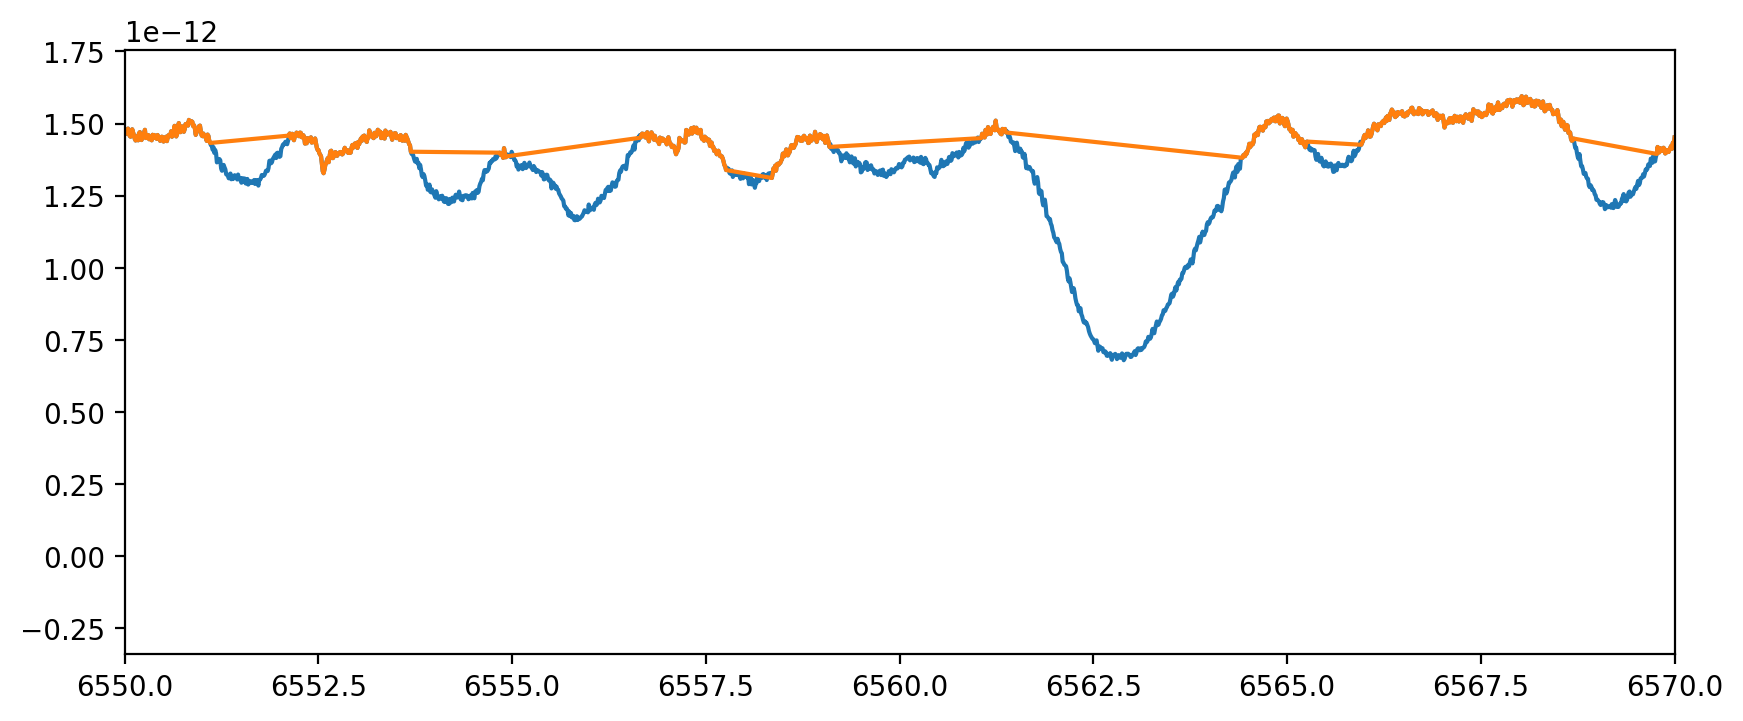

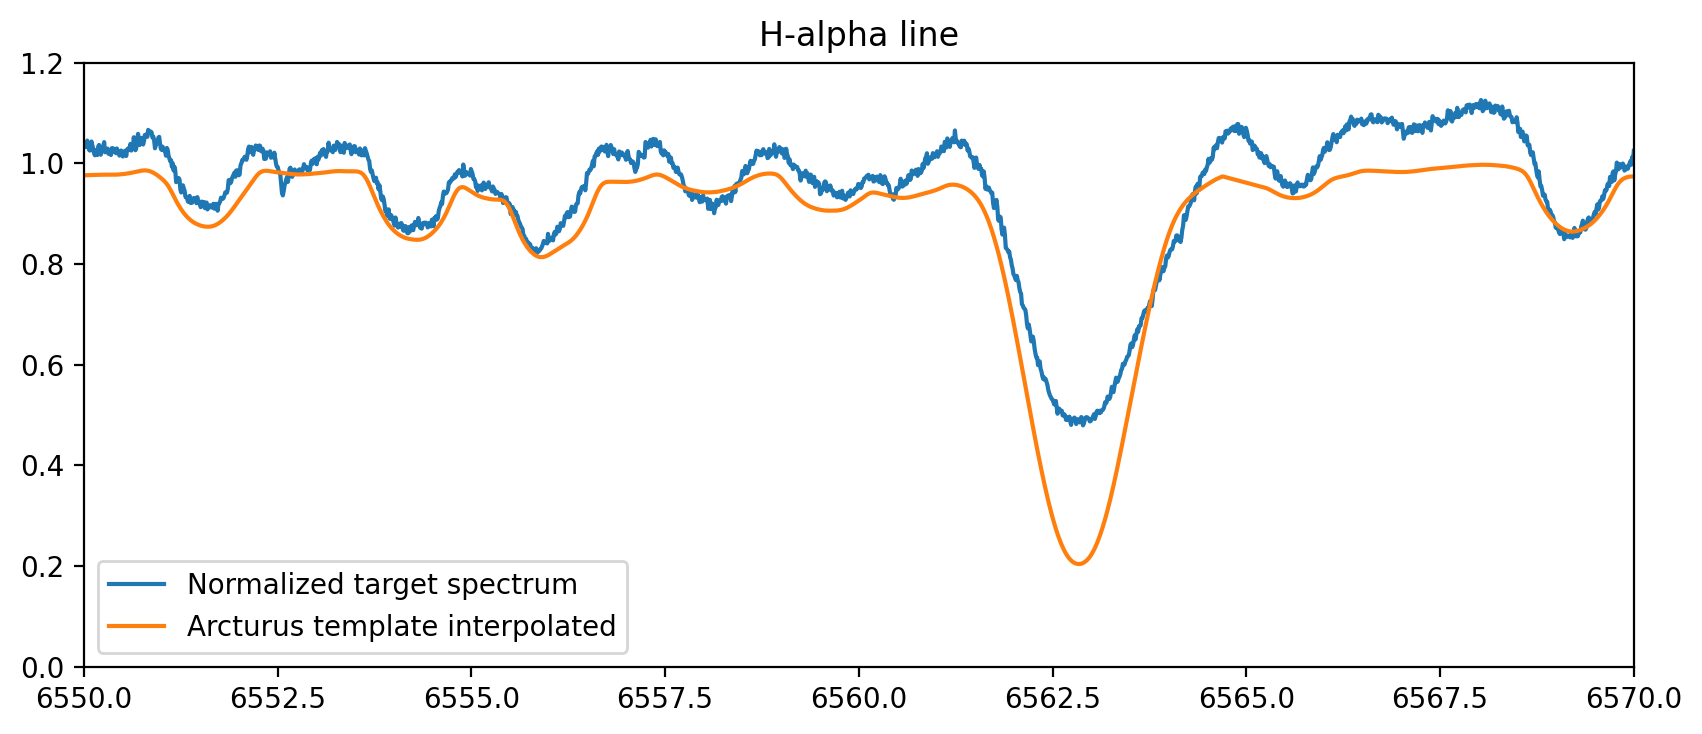

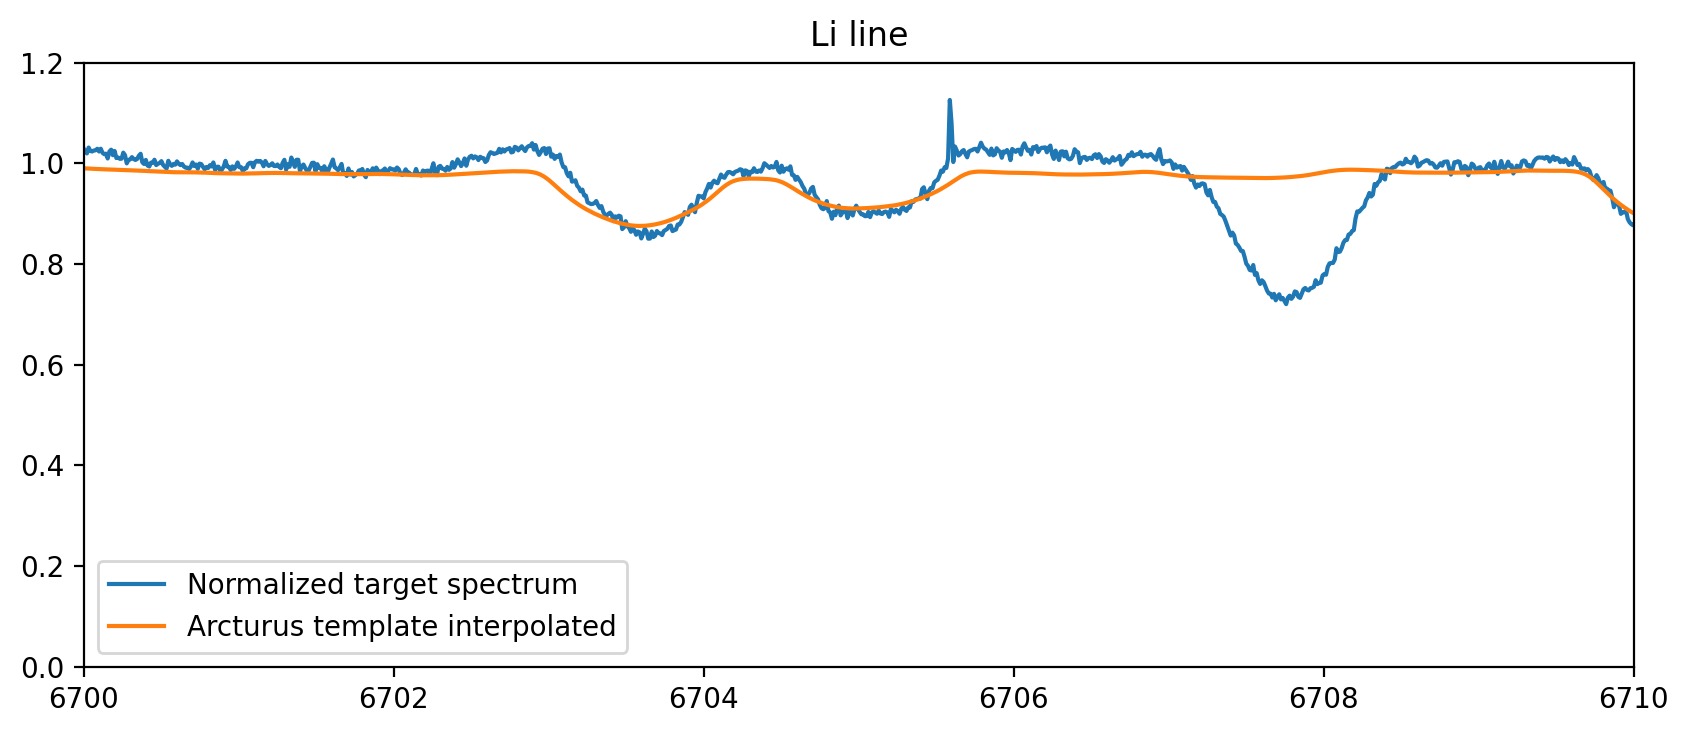

In [78]:
pipeline(21,obj_dir_113,113,close=False)

In [57]:
pipeline(1,obj_dir_112,112,close=True)

11.29 ../files/Arcturus_templates/arcturus_vsini_11.29.txt
N points in target spectrum: 438657
N points in template spectrum: 594711


1
2
7.95
../files/Arcturus_templates/arcturus_vsini_7.95.txt
True
3800.0710748984798 7897.873000355427
N points in target spectrum: 438657
N points in template spectrum: 594566


<Figure size 2000x800 with 0 Axes>

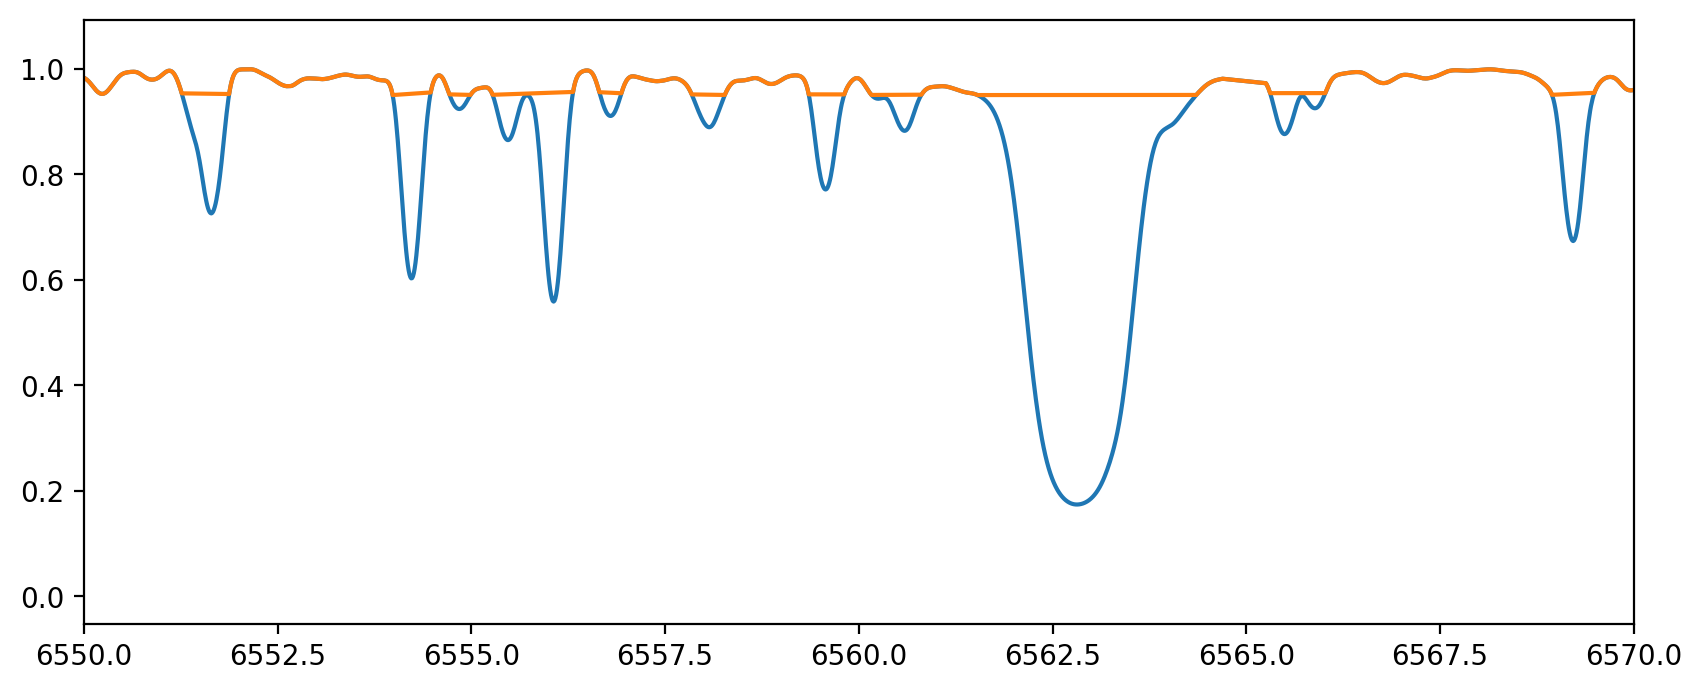

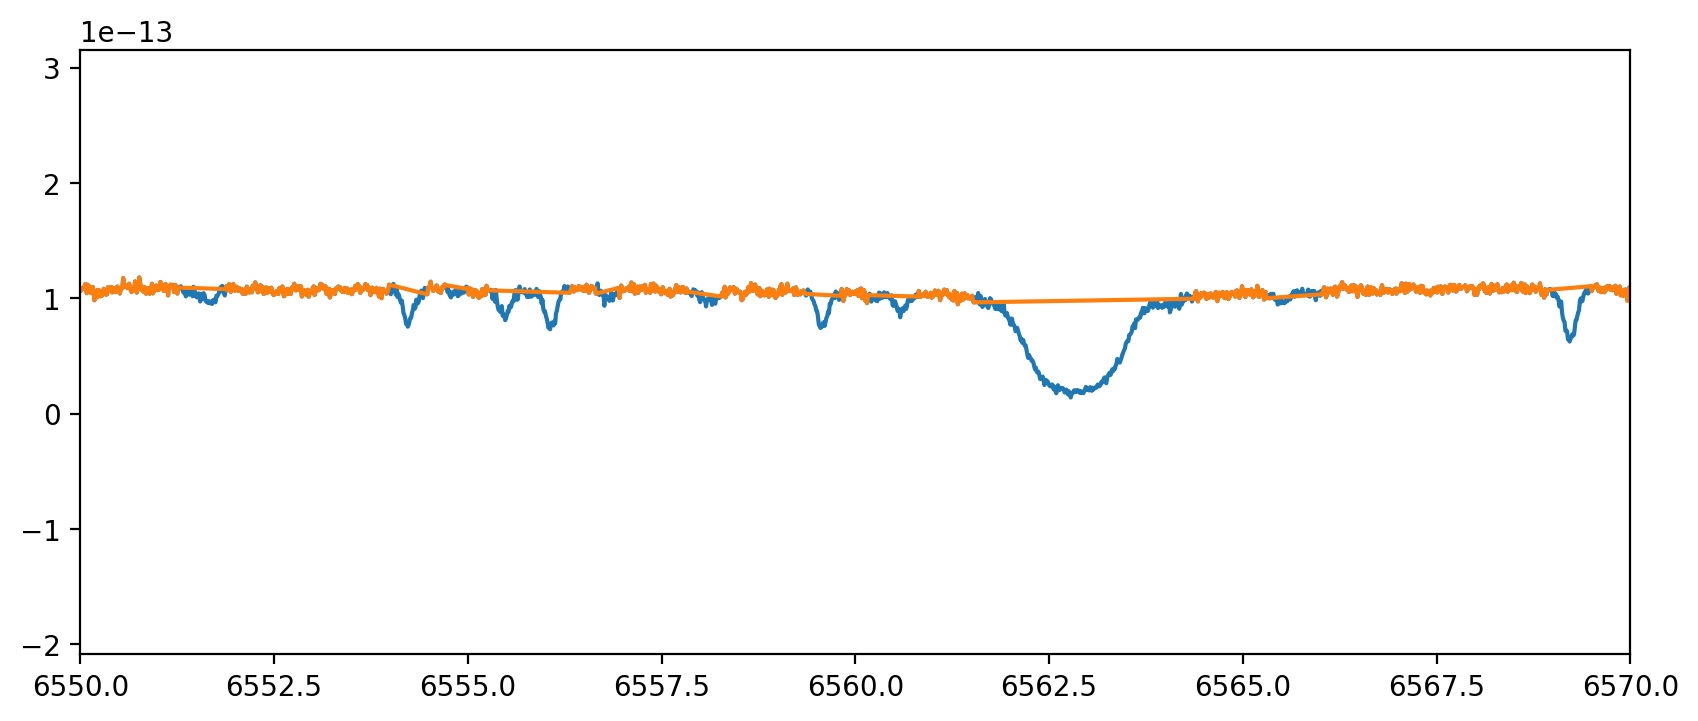

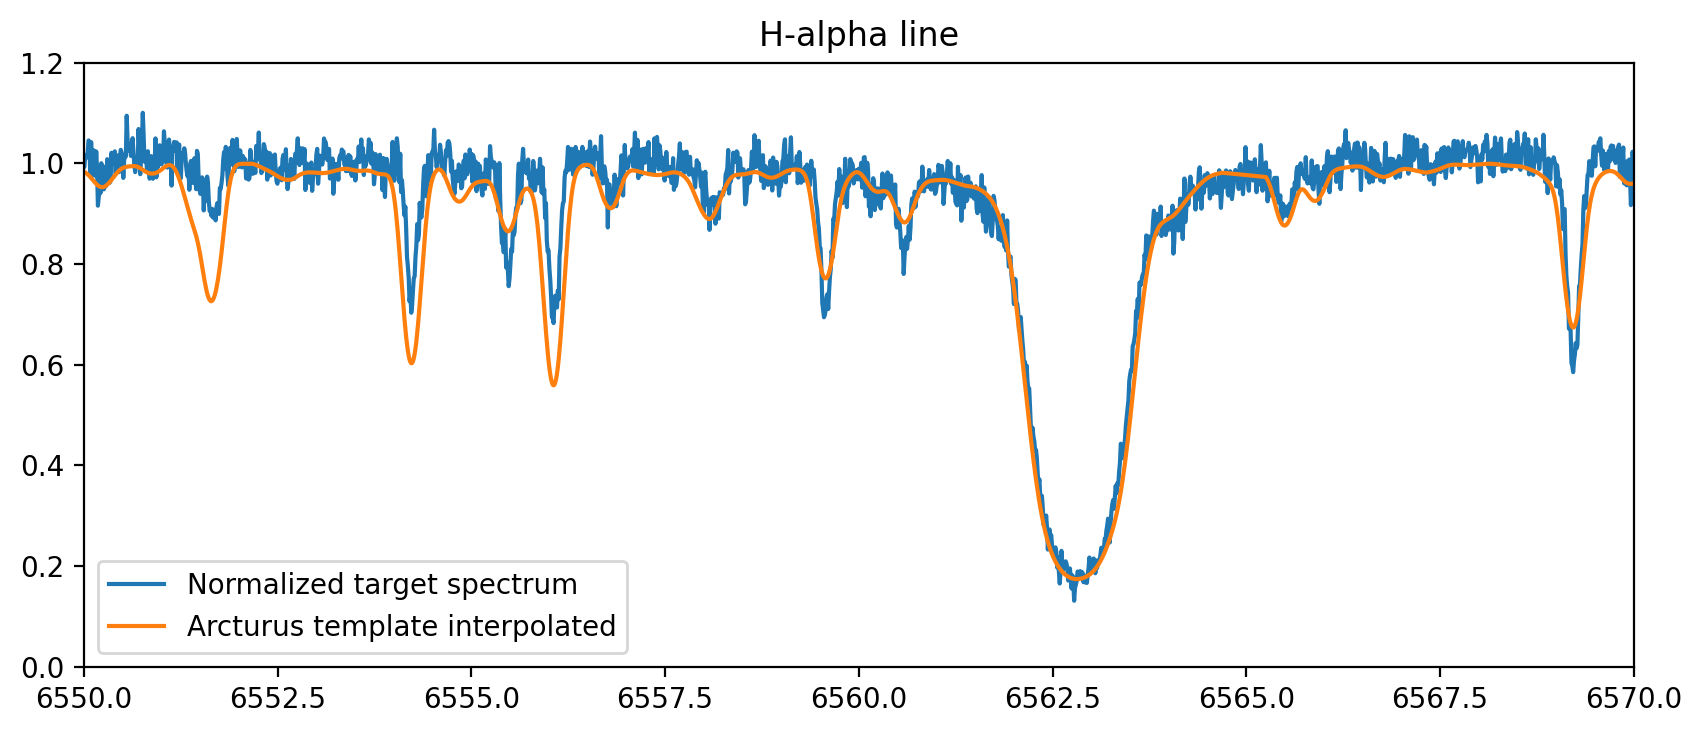

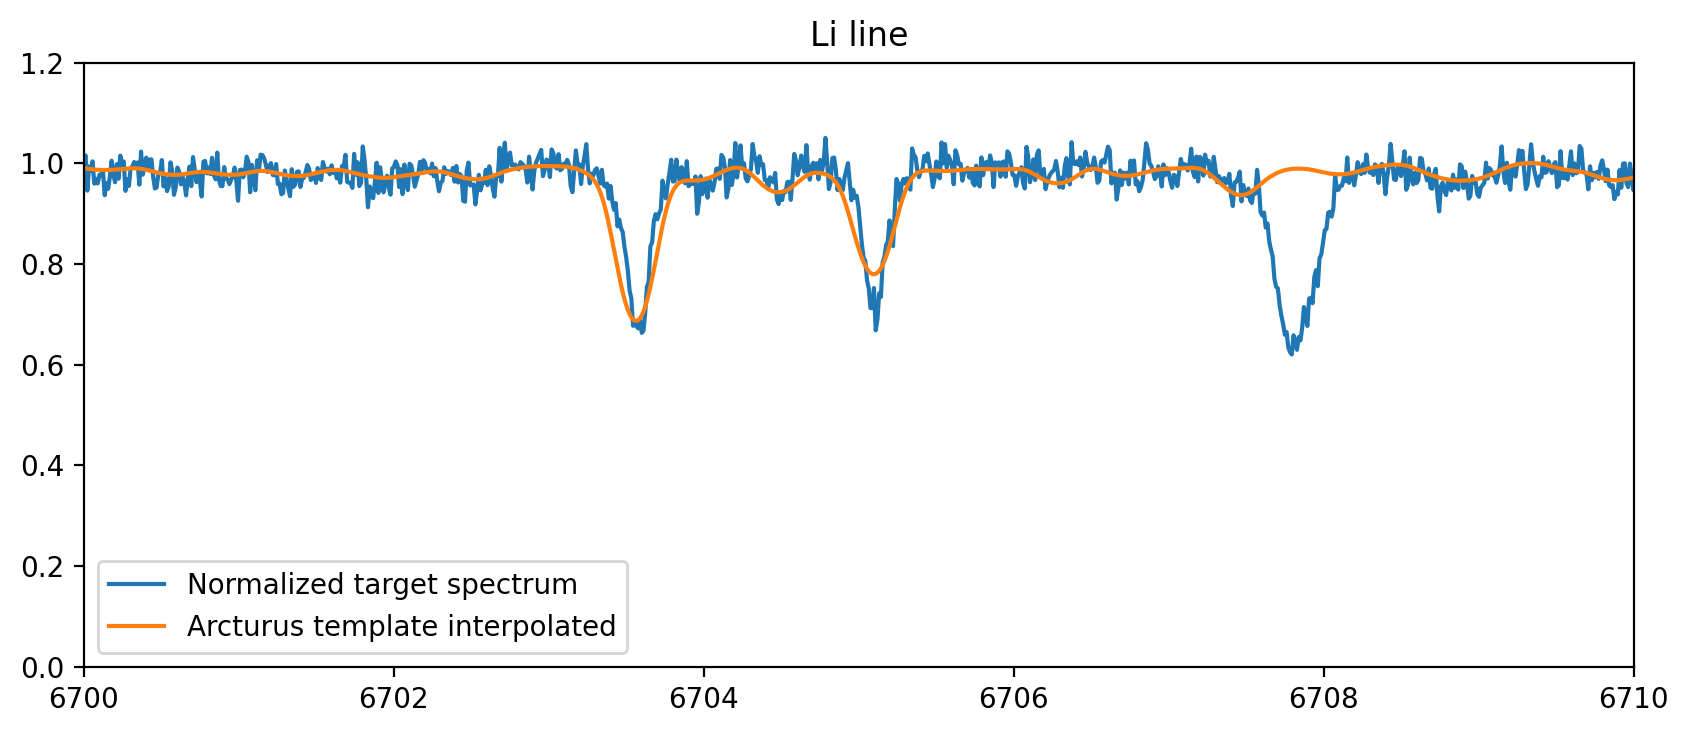

In [43]:
pipeline(6,obj_dir_112,112)

In [ ]:
ss

## Practice with Catherine

In [ ]:
file = files_113[11]
hdul = fits.open(file)
header     = hdul[0].header
data       = hdul[1].data
rv_val     =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
mask       = (wave > 3800)
wave, flux = wave[mask], flux[mask]

plt.figure(figsize=(12,3),dpi=150)
plt.plot(wave, flux)
plt.title(header['OBJECT'])
#     plt.xlim(6550,6570)
plt.xlim(4850, 4870)
plt.ylim(0,0.6e-13)
plt.show()